Import Libraries

In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation
from skimage.measure import label, regionprops
from skimage import io, exposure
from skimage import measure
from skimage import exposure
from czifile import imread
from cellpose import models, plot 
import re
model = models.Cellpose(gpu=False, model_type='cyto3')

Define Sub Functions

In [44]:
def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def otsu_thresholding_c12(channel):
    """Apply Otsu's thresholding to the channel."""
    #.55 for 12225
    bright_image = exposure.adjust_gamma(channel, gamma=0.7)
    threshold_value = threshold_otsu(bright_image)
    print(threshold_value)
    valid = True
    binary_image = bright_image > threshold_value
    return binary_image, valid

def otsu_thresholding_deep_red(channel, path):
    """Apply Otsu's thresholding to the channel."""
    threshold_value = threshold_otsu(channel)
    valid = True
    #if re.search(r"HBSS", path):
    #    print(threshold_value)
    #    disappearing_value = 35000
    #    if threshold_value < disappearing_value:
    #        threshold_value = disappearing_value
    #        valid = False
    disappearing_value = 3200
    if threshold_value < disappearing_value:
        threshold_value = disappearing_value
        valid = False
    binary_image = channel > threshold_value
    return binary_image, valid

def extract_channels(image):
    return image[0], image[1], image[2]

def analyze_image_c12(c12, image_path):
    binary_image, valid = otsu_thresholding_c12(c12)
    if valid == False:
        print(f"bleedthrough detected") 
    #display_image(binary_image, image_path, "c12")
    labled_image = label(binary_image)
    return labled_image

def analyze_image_deep_red(deep_red, image_path):
    binary_image, valid = otsu_thresholding_deep_red(deep_red, image_path)
    if valid == False:
        print(f"bleedthrough detected") 
    #display_image(binary_image, image_path, "deep red")
    labled_image = label(binary_image)
    return labled_image

def deep_red_only(red_mask, c12_mask, path, dilation_size=25):
    """
    Generate a mask containing only the red regions (mask1), excluding adjacent c12 regions.
    The adjacency boundary is expanded using binary dilation.
    """
    # Create a mask of red-only areas by excluding c12 regions
    new_red_mask = np.logical_and(red_mask, np.logical_not(c12_mask))  # Red only
    
    # Check for adjacent pixels between red and c12 regions (boundary detection)
    boundary_mask = np.logical_and(new_red_mask, np.roll(c12_mask, 1, axis=0)) | \
                    np.logical_and(new_red_mask, np.roll(c12_mask, -1, axis=0)) | \
                    np.logical_and(new_red_mask, np.roll(c12_mask, 1, axis=1)) | \
                    np.logical_and(new_red_mask, np.roll(c12_mask, -1, axis=1))
    
    # Apply binary dilation to the boundary mask to expand the boundary
    dilated_boundary = binary_dilation(boundary_mask, structure=np.ones((dilation_size, dilation_size)))  # Expands boundary
    
    # Remove the expanded boundary areas from the red mask
    new_red_mask_clean = np.logical_and(new_red_mask, np.logical_not(dilated_boundary))
    
    # Label the regions in the cleaned red mask
    label_image = label(new_red_mask_clean)
    #display_image(new_red_mask_clean, path, "red only")
    #return new_red_mask_clean
    return label_image

def c12_only(deep_red_mask, c12_mask, path, dilation_size=25):
    """
    Generate a mask containing only the c12 regions (mask2), excluding adjacent red regions.
    The adjacency boundary is expanded using binary dilation.
    """
    # Create a mask of c12-only areas by excluding deep red regions
    new_c12_mask = np.logical_and(np.logical_not(deep_red_mask), c12_mask)  # C12 only
    
    # Check for adjacent pixels between c12 and red regions (boundary detection)
    boundary_mask = np.logical_and(new_c12_mask, np.roll(deep_red_mask, 1, axis=0)) | \
                    np.logical_and(new_c12_mask, np.roll(deep_red_mask, -1, axis=0)) | \
                    np.logical_and(new_c12_mask, np.roll(deep_red_mask, 1, axis=1)) | \
                    np.logical_and(new_c12_mask, np.roll(deep_red_mask, -1, axis=1))
    
    # Apply binary dilation to the boundary mask to expand the boundary
    dilated_boundary = binary_dilation(boundary_mask, structure=np.ones((dilation_size, dilation_size)))  # Expands boundary
    
    # Remove the expanded boundary areas from the c12 mask
    new_c12_mask_clean = np.logical_and(new_c12_mask, np.logical_not(dilated_boundary))
    
    # Label the regions in the cleaned c12 mask
    label_image = label(new_c12_mask_clean)
    #display_image(new_c12_mask_clean, path, "c12 only")
    #return new_c12_mask_clean
    return label_image

def calculate_surface_area(labeled_image):
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)


def circularity_index(mask):
    regions = measure.regionprops(mask)

    # Create empty masks to store the results
    clustered_lds = np.zeros_like(mask, dtype=bool)
    single_lds = np.zeros_like(mask, dtype=bool)

    # Iterate through regions and calculate circularity
    for region in regions:
        area = region.area
        perimeter = measure.perimeter(region.image)
        
        # Avoid division by zero
        if perimeter == 0 or area <= 10:
            continue
        
        circularity = (4 * np.pi * area) / (perimeter ** 2)
        
        # Assign region to the appropriate mask based on circularity
        if circularity < 0.8:
            # Mask for clustered regions
            clustered_lds[region.coords[:, 0], region.coords[:, 1]] = 1
        else:
            # Mask for non-clustered regions
            single_lds[region.coords[:, 0], region.coords[:, 1]] = 1
    
    clustered_lds = clustered_lds.astype(bool)
    single_lds = single_lds.astype(bool)

    return clustered_lds, single_lds

def find_surface_area(mask, path, i, inclusion_mask, type, category) -> int:
    if np.any(mask):
        mask = label(mask)
        surface_area = calculate_surface_area(mask)
        #display_image(mask, path, i+1)
        #print(f"Cell {i + 1} has a {surface_area} surface area of {type} {category}")
        #display_image(inclusion_mask, path, i+1)
        #print(f"Inclusion image of cell {i + 1} above")
    else:
        surface_area = 0
    return surface_area

def find_total_lds_and_surface_area(mask, path, i, type, category) -> int:
    if np.any(mask):
        mask_labeled = label(mask)
        surface_area = calculate_surface_area(mask_labeled)
        number_of_LDS = len(regionprops(mask_labeled))
        #display_image(mask_labeled, path, i+1)
        #print(f"Cell {i + 1} has {type} {number_of_LDS} {category}")
    else:
        surface_area = 0
        number_of_LDS = 0
    return surface_area, number_of_LDS

def find_all_data(applied_mask, total_mask, clustered_mask, single_mask, inclusions, path, i, category) -> int:
    LDS_in_cell = (applied_mask & total_mask)
    clustered_LDS_in_cell = (applied_mask & clustered_mask)
    single_LDS_in_cell = (applied_mask & single_mask)
    surface_area_LDS, number_of_LDS = find_total_lds_and_surface_area(LDS_in_cell, path, i, "total LDS", category) 
    surface_area_clustered_LDS, number_of_clustered_LDS = find_total_lds_and_surface_area(clustered_LDS_in_cell, path, i, "clustered LDS", category)  
    surface_area_single_LDS, number_of_single_LDS = find_total_lds_and_surface_area(single_LDS_in_cell, path, i, "single LDS", category)
        
    LDS_in_inclusion = (inclusions & total_mask)
    surface_area_LDS_in_inclusion = find_surface_area(LDS_in_inclusion, path, i, inclusions, "LDS in inclusion", category)

    LDS_not_in_inclusion = LDS_in_cell & ~LDS_in_inclusion
    surface_area_LDS_not_in_inclusion = find_surface_area(LDS_not_in_inclusion, path, i, inclusions, "LDS not in inclusion", category)

    total_clustered_LDS_in_inclusion = (inclusions & clustered_mask)
    surface_area_clustered_LDS_in_inclusion = find_surface_area(total_clustered_LDS_in_inclusion, path, i, inclusions, "clustered LDS in inclusion", category)

    total_clustered_LDS_not_in_inclusion = clustered_LDS_in_cell & ~total_clustered_LDS_in_inclusion
    surface_area_clustered_LDS_not_in_inclusion = find_surface_area(total_clustered_LDS_not_in_inclusion, path, i, inclusions, "clustered LDS not in inclusion", category)

    total_single_LDS_in_inclusion = (inclusions & single_mask)
    surface_area_single_LDS_in_inclusion = find_surface_area(total_single_LDS_in_inclusion, path, i, inclusions, "single LDS in inclusion", category)

    total_single_LDS_not_in_inclusion = single_LDS_in_cell & ~total_single_LDS_in_inclusion
    surface_area_single_LDS_not_in_inclusion = find_surface_area(total_single_LDS_not_in_inclusion, path, i, inclusions, "single LDS not in inclusion", category)

    return surface_area_LDS, number_of_LDS, surface_area_clustered_LDS, number_of_clustered_LDS, surface_area_single_LDS, number_of_single_LDS, surface_area_LDS_in_inclusion, surface_area_LDS_not_in_inclusion, surface_area_clustered_LDS_in_inclusion, surface_area_clustered_LDS_not_in_inclusion, surface_area_single_LDS_in_inclusion, surface_area_single_LDS_not_in_inclusion

def cell_pose(channel, path, red_total, c12_total, red_only, c12_only):
    bright_image = exposure.adjust_gamma(channel, gamma=0.5)  # Gamma < 1 makes it brighter
    masks, flows, styles, diams = model.eval(bright_image, diameter=280, channels=[0, 0])
    labeled_cells = label(masks)
    
    cell_data = []

    filtered_cells = [cell for cell in regionprops(labeled_cells) if cell.area >= 100]

    clustered_c12_total, single_c12_total = circularity_index(c12_total)
    clustered_red_total, single_red_total = circularity_index(red_total)
    clustered_c12_only, single_c12_only = circularity_index(c12_only)
    clustered_red_only, single_red_only = circularity_index(red_only)
    display_image(labeled_cells, path, "cellpose")
    for i, cell in enumerate(filtered_cells):
        mask = labeled_cells == cell.label
        applied_mask = gaussian(channel) * mask
        threshold = 0.3
        inclusions = applied_mask > threshold
        inclusions_labeled = label(inclusions)

        inclusion_size = []
        inclusion_size_swiss = []
        inclusion_size_solid = []

        

        #if len(regionprops(inclusions_labeled)) > 0:
        #    display_image(inclusions, path, i+1)

        applied_mask = applied_mask > 0  # Convert to boolean if not already
        red_total = red_total > 0  # Convert to boolean if not already
        c12_total = c12_total > 0  # Convert to boolean if not already
        red_only = red_only > 0  # Convert to boolean if not already
        c12_only = c12_only > 0  # Convert to boolean if not already
        inclusions = inclusions > 0  # Convert to boolean if not already

        
        total_surface_area_C12_LDS, total_C12_LDS, total_surface_area_clustered_C12_LDS, total_clustered_C12_LDS, total_surface_area_single_C12_LDS, total_single_C12_LDS, surface_area_C12_total_LDS_in_inclusion, surface_area_C12_total_LDS_not_in_inclusion, surface_area_clustered_C12_LDS_in_inclusion, surface_area_clustered_C12_LDS_not_in_inclusion, surface_area_single_C12_LDS_in_inclusion, surface_area_single_C12_LDS_not_in_inclusion = find_all_data(applied_mask, c12_total, clustered_c12_total, single_c12_total, inclusions, path, i, "total c12")
        
        total_surface_area_red_LDS, total_red_LDS, total_surface_area_clustered_red_LDS, total_clustered_red_LDS, total_surface_area_single_red_LDS, total_single_red_LDS, surface_area_total_red_LDS_in_inclusion, surface_area_total_red_LDS_not_in_inclusion, surface_area_clustered_red_LDS_in_inclusion, surface_area_clustered_red_LDS_not_in_inclusion, surface_area_single_red_LDS_in_inclusion, surface_area_single_red_LDS_not_in_inclusion = find_all_data(applied_mask, red_total, clustered_red_total, single_red_total, inclusions, path, i, "total red")
        
        total_surface_area_red_LDS_only, total_red_LDS_only, total_surface_area_clustered_red_LDS_only, total_clustered_red_LDS_only, total_surface_area_single_red_LDS_only, total_single_red_LDS_only, surface_area_total_red_LDS_only_in_inclusion, surface_area_total_red_LDS_only_not_in_inclusion, surface_area_clustered_red_LDS_only_in_inclusion, surface_area_clustered_red_LDS_only_not_in_inclusion, surface_area_single_red_LDS_only_in_inclusion, surface_area_single_red_LDS_only_not_in_inclusion = find_all_data(applied_mask, red_only, clustered_red_only, single_red_only, inclusions, path, i, "c12 only")

        total_surface_area_C12_LDS_only, total_C12_LDS_only, total_surface_area_clustered_C12_LDS_only, total_clustered_C12_LDS_only, total_surface_area_single_C12_LDS_only, total_single_C12_LDS_only, surface_area_total_C12_LDS_only_in_inclusion, surface_area_total_C12_LDS_only_not_in_inclusion, surface_area_clustered_C12_LDS_only_in_inclusion, surface_area_clustered_C12_LDS_only_not_in_inclusion, surface_area_single_C12_LDS_only_in_inclusion, surface_area_single_C12_LDS_only_not_in_inclusion = find_all_data(applied_mask, c12_only, clustered_c12_only, single_c12_only, inclusions, path, i, "red only")


        for inclusion in regionprops(inclusions_labeled):
            if inclusion.area > 10:
                inclusion_mask = inclusions_labeled == inclusion.label
                LDS_in_inclusion = (inclusion_mask & red_total) | (inclusion_mask & c12_total)
                inclusion_size.append(inclusion.area)

                # Determine inclusion type based on lipid presence
                if np.any(LDS_in_inclusion):
                    inclusion_size_swiss.append(inclusion.area)
                    type = "swiss"
                else:
                    inclusion_size_solid.append(inclusion.area)
                    type = "solid"
                #print(f"{inclusion.area} {type} inclusion in cell {cell.label}")

        if not inclusion_size:
            cell_data.append({
                'Filename': path,
                'Cell Number': i + 1,
                'Cytoplasm Surface Area': cell.area,
                'Total Number of Inclusions': None,  # No inclusion number
                'Average of Total Inclusion Surface Area': 0,  # No inclusion surface area
                'Number of Solid Inclusions': 0,
                'Average Solid Inclusion Surface Area': 0,  # Average surface area of solid inclusions
                'Number of Swiss Inclusions': 0,
                'Average Swiss Inclusion Surface Area': 0,  # Surface area of this inclusion
                'Number of Clustered C12 Total LDS': total_clustered_C12_LDS,
                'Surface area of Clustered C12 Total LDS': total_surface_area_clustered_C12_LDS,
                'Surface area of Clustered C12 Total LDS in inclusion': surface_area_clustered_C12_LDS_in_inclusion,
                'Surface area of Clustered C12 Total LDS not in inclusion': surface_area_clustered_C12_LDS_not_in_inclusion,
                'Number of Single C12 Total LDS': total_single_C12_LDS,
                'Surface area of Single C12 Total LDS': total_surface_area_single_C12_LDS,
                'Surface area of Single C12 Total LDS in inclusion': surface_area_single_C12_LDS_in_inclusion,
                'Surface area of Single C12 Total LDS not in inclusion': surface_area_single_C12_LDS_not_in_inclusion,
                'Number of C12 Total LDS': total_C12_LDS,
                'Surface area of C12 Total LDS': total_surface_area_C12_LDS,
                'Surface area of C12 Total LDS in inclusion': surface_area_C12_total_LDS_in_inclusion,
                'Surface area of C12 Total LDS not in inclusion': surface_area_C12_total_LDS_not_in_inclusion,
                'Number of Clustered Red Total LDS': total_clustered_red_LDS,
                'Surface area of Clustered Red Total LDS': total_surface_area_clustered_red_LDS,
                'Surface area of Clustered Red Total LDS in inclusion': surface_area_clustered_red_LDS_in_inclusion,
                'Surface area of Clustered Red Total LDS not in inclusion': surface_area_clustered_red_LDS_not_in_inclusion,
                'Number of Single Red Total LDS': total_single_red_LDS,
                'Surface area of Single Red Total LDS': total_surface_area_single_red_LDS,
                'Surface area of Single Red Total LDS in inclusion': surface_area_single_red_LDS_in_inclusion,
                'Surface area of Single Red Total LDS not in inclusion': surface_area_single_red_LDS_not_in_inclusion,
                'Number of Red Total LDS': total_red_LDS,
                'Surface area of Red Total LDS': total_surface_area_red_LDS,
                'Surface area of Red Total LDS in inclusion': surface_area_total_red_LDS_in_inclusion,
                'Surface area of Red Total LDS not in inclusion': surface_area_total_red_LDS_not_in_inclusion,
                'Number of Clustered C12 LDS Only': total_clustered_C12_LDS_only,
                'Surface area of Clustered C12 LDS Only': total_surface_area_clustered_C12_LDS_only,
                'Surface area of Clustered C12 LDS Only in inclusion': surface_area_clustered_C12_LDS_only_in_inclusion,
                'Surface area of Clustered C12 LDS Only not in inclusion': surface_area_clustered_C12_LDS_only_not_in_inclusion,
                'Number of Single C12 LDS Only': total_single_C12_LDS_only,
                'Surface area of Single C12 LDS Only': total_surface_area_single_C12_LDS_only,
                'Surface area of Single C12 LDS Only in inclusion': surface_area_single_C12_LDS_only_in_inclusion,
                'Surface area of Single C12 LDS Only not in inclusion': surface_area_single_C12_LDS_only_not_in_inclusion,
                'Number of C12 LDS Only': total_C12_LDS_only,
                'Surface area of C12 LDS Only': total_surface_area_C12_LDS_only,
                'Surface area of C12 LDS Only in inclusion': surface_area_total_C12_LDS_only_in_inclusion,
                'Surface area of C12 LDS Only not in inclusion': surface_area_total_C12_LDS_only_not_in_inclusion,
                'Number of Clustered Red LDS Only': total_clustered_red_LDS_only,
                'Surface area of Clustered Red LDS Only': total_surface_area_clustered_red_LDS_only,
                'Surface area of Clustered Red LDS Only in inclusion': surface_area_clustered_red_LDS_only_in_inclusion,
                'Surface area of Clustered Red LDS Only not in inclusion': surface_area_clustered_red_LDS_only_not_in_inclusion,
                'Number of Single Red LDS Only': total_single_red_LDS_only,
                'Surface area of Single Red LDS Only': total_surface_area_single_red_LDS_only,
                'Surface area of Single Red LDS Only in inclusion': surface_area_single_red_LDS_only_in_inclusion,
                'Surface area of Single Red LDS Only not in inclusion': surface_area_single_red_LDS_only_not_in_inclusion,
                'Number of Red LDS Only': total_red_LDS_only,
                'Surface area of Red LDS Only': total_surface_area_red_LDS_only,
                'Surface area of Red LDS Only in inclusion': surface_area_total_red_LDS_only_in_inclusion,
                'Surface area of Red LDS Only not in inclusion': surface_area_total_red_LDS_only_not_in_inclusion
            })
        else:
            total_inclusions = len(inclusion_size)  # Total number of inclusions
            average_surface_area = sum(inclusion_size) / total_inclusions  # Average surface area

            number_of_solid_inclusions = len(inclusion_size_solid)  

            if number_of_solid_inclusions == 0:
                average_surface_area_solid = 0
            else: 
                average_surface_area_solid = sum(inclusion_size_solid) / number_of_solid_inclusions

            number_of_swiss_inclusions = len(inclusion_size_swiss) 

            if number_of_swiss_inclusions == 0:
                average_surface_area_swiss = 0
            else:
                # Avoid division by zero for average surface area of swiss inclusions
                average_surface_area_swiss = sum(inclusion_size_swiss) / number_of_swiss_inclusions

            cell_data.append({
                'Filename': path,
                'Cell Number': i + 1,
                'Cytoplasm Surface Area': cell.area,
                'Total Number of Inclusions': total_inclusions, 
                'Average of Total Inclusion Surface Area': average_surface_area,  # Average surface area of inclusions
                'Number of Solid Inclusions': number_of_solid_inclusions,
                'Average Solid Inclusion Surface Area': average_surface_area_solid,  # Average surface area of solid inclusions
                'Number of Swiss Inclusions': number_of_swiss_inclusions,
                'Average Swiss Inclusion Surface Area': average_surface_area_swiss,  # Surface area of this inclusion
                'Number of Clustered C12 Total LDS': total_clustered_C12_LDS,
                'Surface area of Clustered C12 Total LDS': total_surface_area_clustered_C12_LDS,
                'Surface area of Clustered C12 Total LDS in inclusion': surface_area_clustered_C12_LDS_in_inclusion,
                'Surface area of Clustered C12 Total LDS not in inclusion': surface_area_clustered_C12_LDS_not_in_inclusion,
                'Number of Single C12 Total LDS': total_single_C12_LDS,
                'Surface area of Single C12 Total LDS': total_surface_area_single_C12_LDS,
                'Surface area of Single C12 Total LDS in inclusion': surface_area_single_C12_LDS_in_inclusion,
                'Surface area of Single C12 Total LDS not in inclusion': surface_area_single_C12_LDS_not_in_inclusion,
                'Number of C12 Total LDS': total_C12_LDS,
                'Surface area of C12 Total LDS': total_surface_area_C12_LDS,
                'Surface area of C12 Total LDS in inclusion': surface_area_C12_total_LDS_in_inclusion,
                'Surface area of C12 Total LDS not in inclusion': surface_area_C12_total_LDS_not_in_inclusion,
                'Number of Clustered Red Total LDS': total_clustered_red_LDS,
                'Surface area of Clustered Red Total LDS': total_surface_area_clustered_red_LDS,
                'Surface area of Clustered Red Total LDS in inclusion': surface_area_clustered_red_LDS_in_inclusion,
                'Surface area of Clustered Red Total LDS not in inclusion': surface_area_clustered_red_LDS_not_in_inclusion,
                'Number of Single Red Total LDS': total_single_red_LDS,
                'Surface area of Single Red Total LDS': total_surface_area_single_red_LDS,
                'Surface area of Single Red Total LDS in inclusion': surface_area_single_red_LDS_in_inclusion,
                'Surface area of Single Red Total LDS not in inclusion': surface_area_single_red_LDS_not_in_inclusion,
                'Number of Red Total LDS': total_red_LDS,
                'Surface area of Red Total LDS': total_surface_area_red_LDS,
                'Surface area of Red Total LDS in inclusion': surface_area_total_red_LDS_in_inclusion,
                'Surface area of Red Total LDS not in inclusion': surface_area_total_red_LDS_not_in_inclusion,
                'Number of Clustered C12 LDS Only': total_clustered_C12_LDS_only,
                'Surface area of Clustered C12 LDS Only': total_surface_area_clustered_C12_LDS_only,
                'Surface area of Clustered C12 LDS Only in inclusion': surface_area_clustered_C12_LDS_only_in_inclusion,
                'Surface area of Clustered C12 LDS Only not in inclusion': surface_area_clustered_C12_LDS_only_not_in_inclusion,
                'Number of Single C12 LDS Only': total_single_C12_LDS_only,
                'Surface area of Single C12 LDS Only': total_surface_area_single_C12_LDS_only,
                'Surface area of Single C12 LDS Only in inclusion': surface_area_single_C12_LDS_only_in_inclusion,
                'Surface area of Single C12 LDS Only not in inclusion': surface_area_single_C12_LDS_only_not_in_inclusion,
                'Number of C12 LDS Only': total_C12_LDS_only,
                'Surface area of C12 LDS Only': total_surface_area_C12_LDS_only,
                'Surface area of C12 LDS Only in inclusion': surface_area_total_C12_LDS_only_in_inclusion,
                'Surface area of C12 LDS Only not in inclusion': surface_area_total_C12_LDS_only_not_in_inclusion,
                'Number of Clustered Red LDS Only': total_clustered_red_LDS_only,
                'Surface area of Clustered Red LDS Only': total_surface_area_clustered_red_LDS_only,
                'Surface area of Clustered Red LDS Only in inclusion': surface_area_clustered_red_LDS_only_in_inclusion,
                'Surface area of Clustered Red LDS Only not in inclusion': surface_area_clustered_red_LDS_only_not_in_inclusion,
                'Number of Single Red LDS Only': total_single_red_LDS_only,
                'Surface area of Single Red LDS Only': total_surface_area_single_red_LDS_only,
                'Surface area of Single Red LDS Only in inclusion': surface_area_single_red_LDS_only_in_inclusion,
                'Surface area of Single Red LDS Only not in inclusion': surface_area_single_red_LDS_only_not_in_inclusion,
                'Number of Red LDS Only': total_red_LDS_only,
                'Surface area of Red LDS Only': total_surface_area_red_LDS_only,
                'Surface area of Red LDS Only in inclusion': surface_area_total_red_LDS_only_in_inclusion,
                'Surface area of Red LDS Only not in inclusion': surface_area_total_red_LDS_only_not_in_inclusion
            })
    df_cell_summary = pd.DataFrame(cell_data)

    return df_cell_summary

Main Function

8220


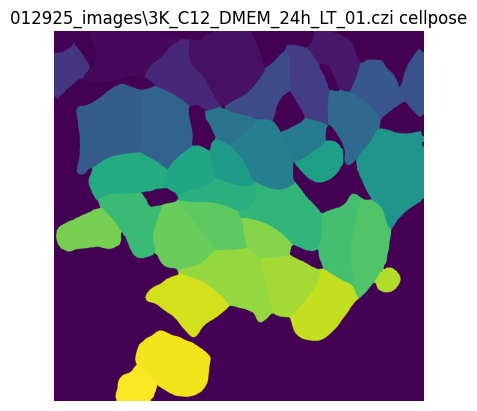

9229


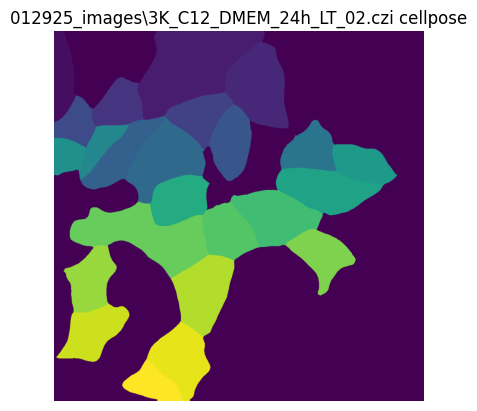

8266


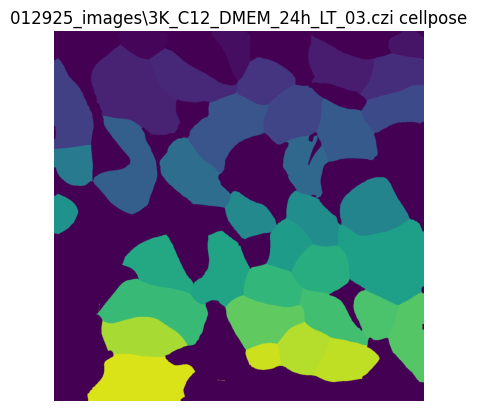

11786


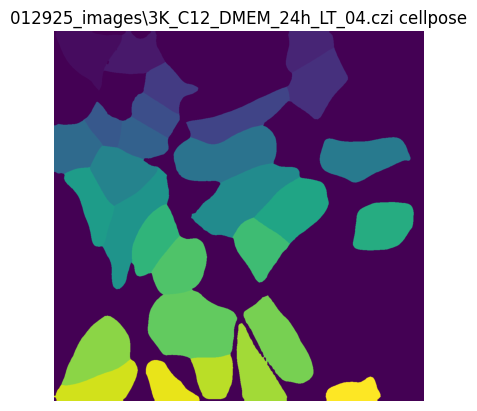

9295


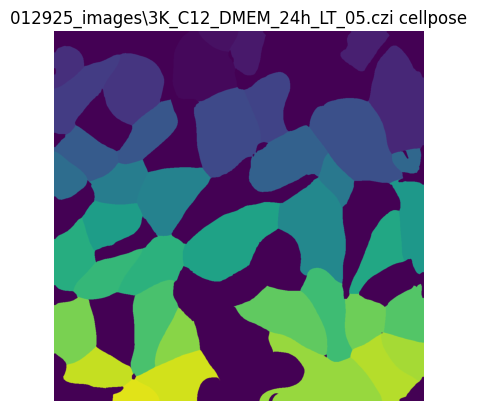

10954


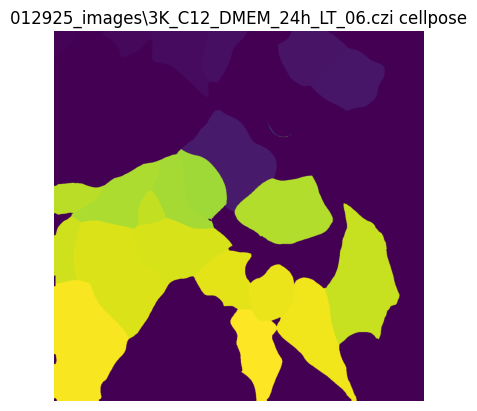

5213
bleedthrough detected


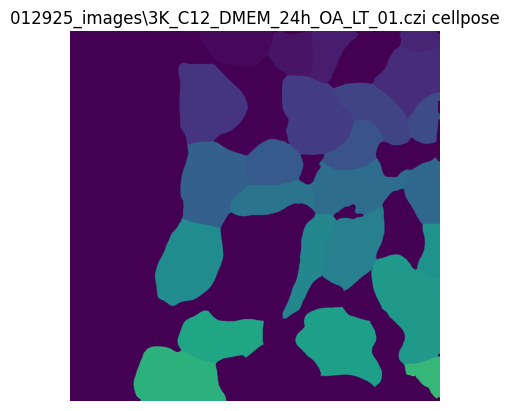

4975


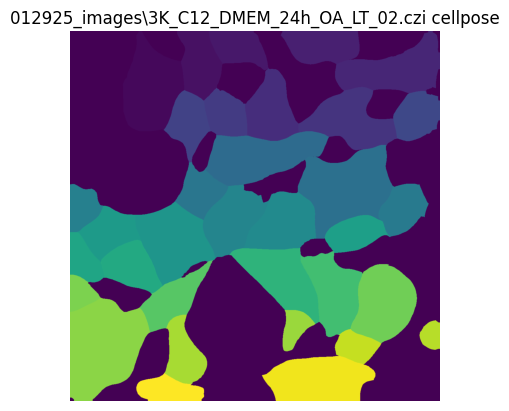

5550


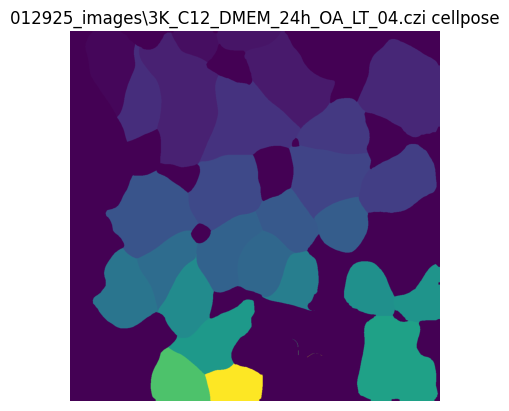

5838


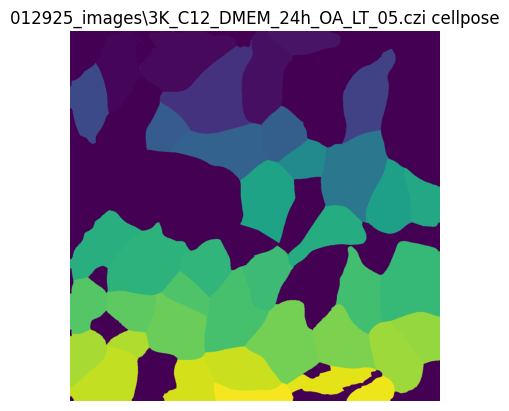

6832


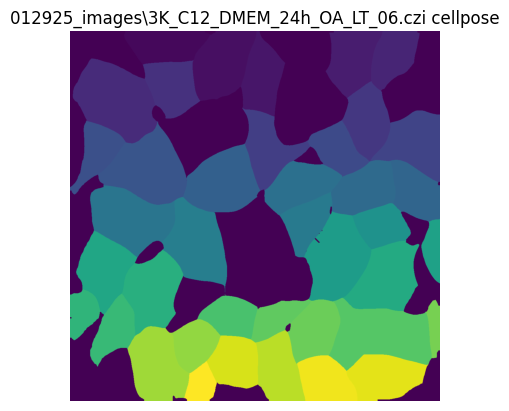

11378


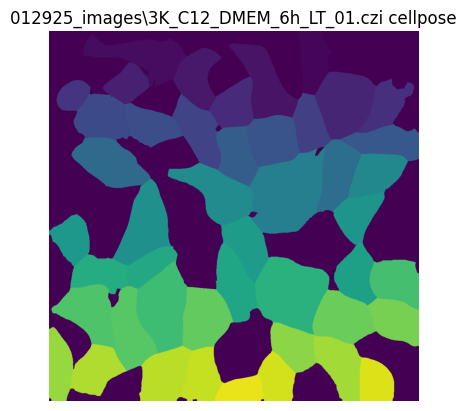

13302


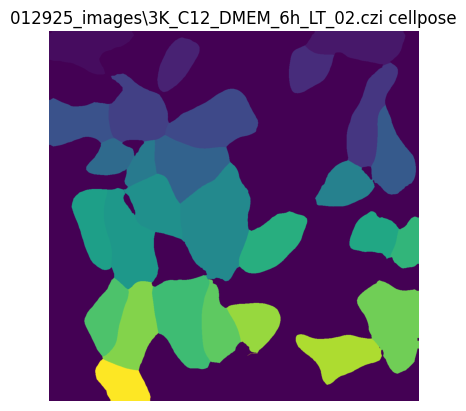

15662


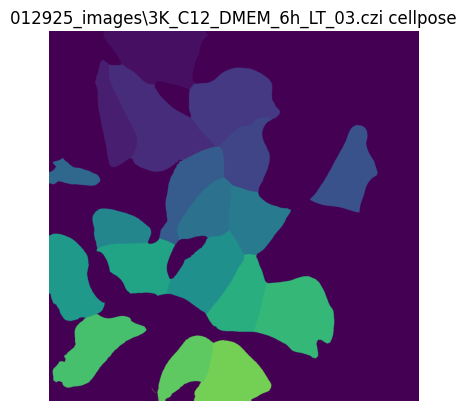

12289


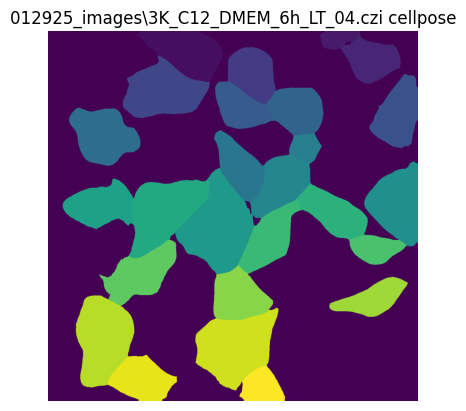

12732


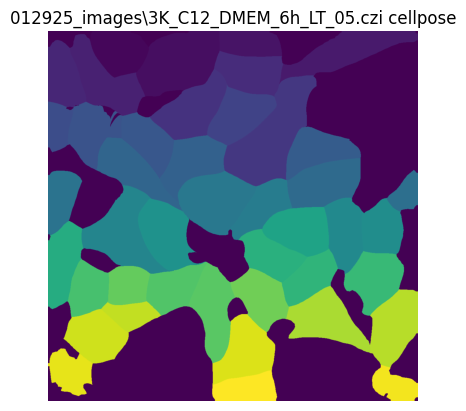

14326


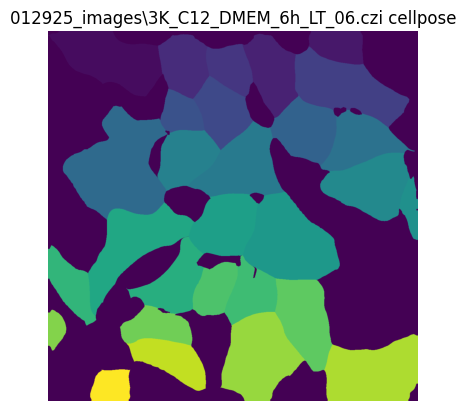

16659


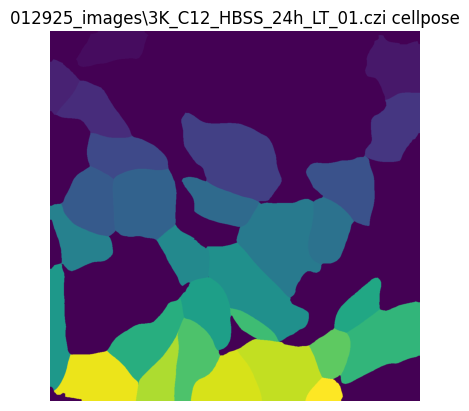

15741


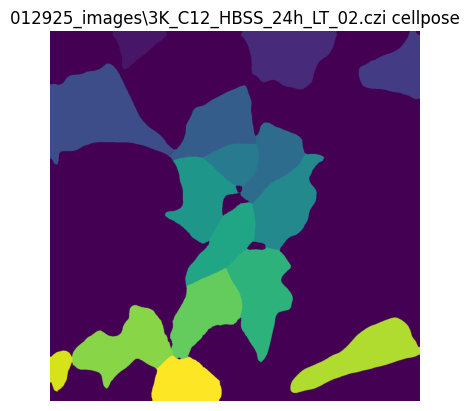

13910


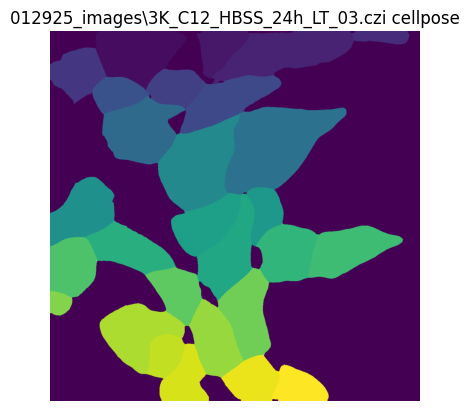

17480


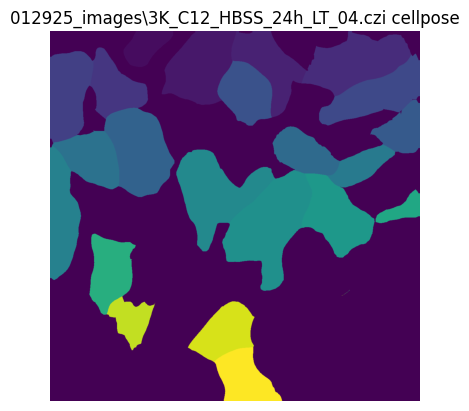

14847


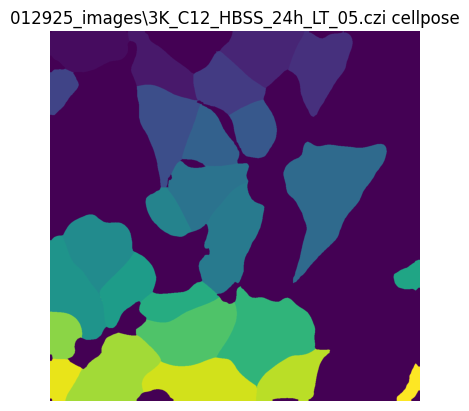

15166


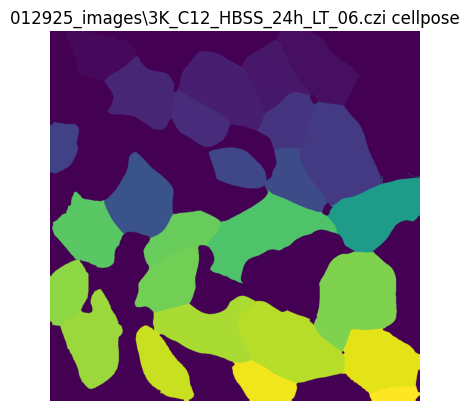

21412


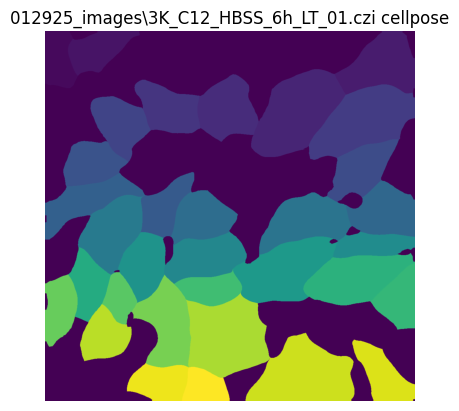

21744


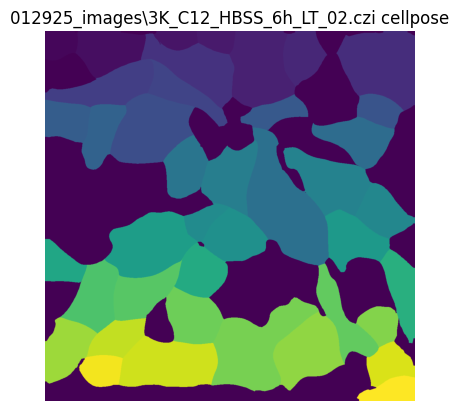

20058


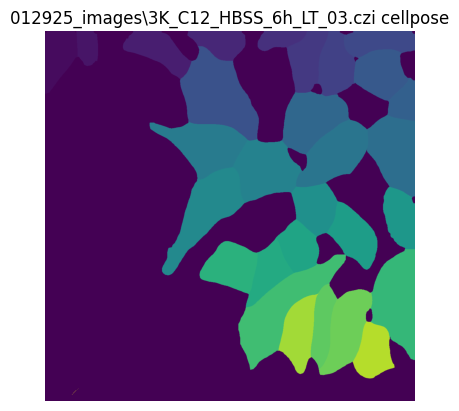

21050


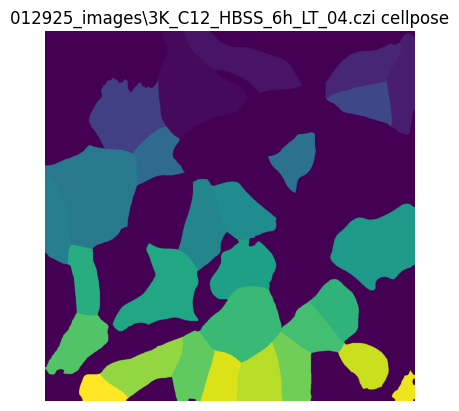

19144


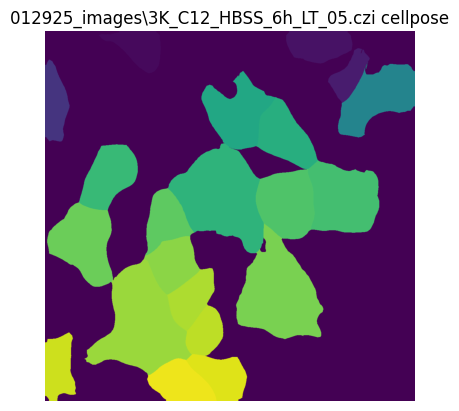

19872


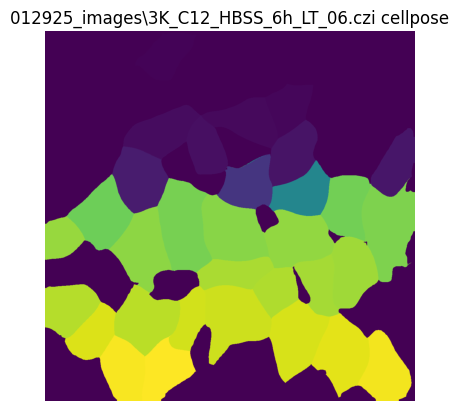

In [45]:
def main(image_folder):

    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()
    df_cell_summary_list = []
    # Iterate over each image
    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 
        deep_red, c12, green_channel = extract_channels(image_squeezed)

        c12_mask = analyze_image_c12(c12, path)
        deep_red_mask = analyze_image_deep_red(deep_red, path)

        deep_red_only_mask = deep_red_only(deep_red_mask, c12_mask, path)
        c12_only_mask = c12_only(deep_red_mask, c12_mask, path)

        #display_image(c12_mask, path, "c12")
        #display_image(deep_red_mask, path, "deep red")
        #display_image(c12_only_mask, path, "c12 only")
        #display_image(deep_red_only_mask, path, "deep red only")
        
        #clustered_mask, single_mask = circularity_index(c12_mask)
        #display_image(clustered_mask, path, "clustered c12")
        #display_image(single_mask, path, "single c12")


        df_cell_summary = cell_pose(green_channel, path, deep_red_mask, c12_mask, deep_red_only_mask, c12_only_mask)
        df_cell_summary_list.append(df_cell_summary)
        
    combined_cell_summary_df = pd.concat(df_cell_summary_list, ignore_index=True)
    output_summary_path = os.path.join(output_dir, '012925_SUMMARY.xlsx')
    combined_cell_summary_df.to_excel(output_summary_path, index=False)

if __name__ == "__main__":
    image_folder = '012925_images'
    main(image_folder)